## Exercise 1.4 Hotdog -- no hotdog
This is the first poster hand-in exercise for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
from numba import jit

We always check that we are running on a GPU

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
if torch.backends.mps.is_available():
    print("The code will run on GPU.")
else:
    print ("MPS device not found.")

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [5]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5226, 0.4412, 0.3585], std=[0.2253, 0.2294, 0.2339])])

test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5226, 0.4412, 0.3585], std=[0.2253, 0.2294, 0.2339])])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.5226, 0.4412, 0.3585], std=[0.2253, 0.2294, 0.2339])])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.5226, 0.4412, 0.3585], std=[0.2253, 0.2294, 0.2339])])

batch_size = 32
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
DATA_MEANS = (trainset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (testset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Let's look at some images from our data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

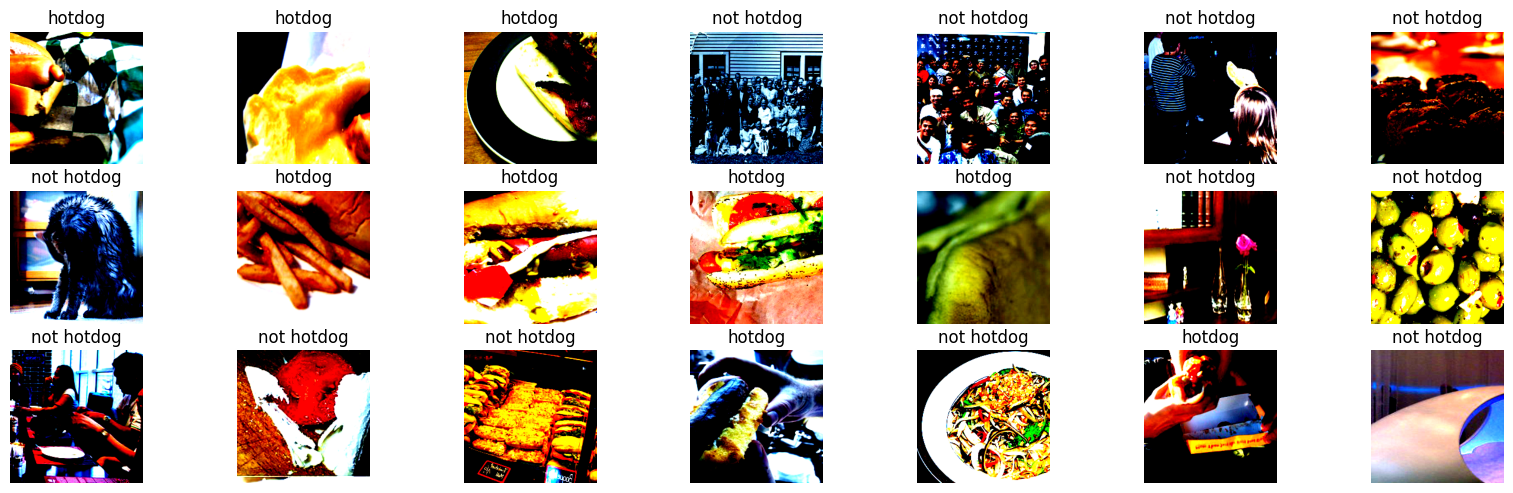

In [6]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [7]:
class ResNetBlock(nn.Module):
    def __init__(self, c_in, act_fn=nn.ReLU, c_out=-1, channel_change=False, strides=1):
        '''
        Args:
            c_in: number of input features
            act_fn: activation function
            c_out: number of output features
        '''
        super().__init__()

        self.act_fn = act_fn()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out, device=device),
            self.act_fn,
            nn.Conv2d(in_channels=c_out, out_channels=c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out),
        )
        
        if channel_change:
            self.conv3 = nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None

    def forward(self, x):
        z = self.net(x)
        if self.conv3:
            x = self.conv3(x)
        out = x + z
        out = self.act_fn(out)
        return out

In [8]:
block = ResNetBlock(c_in=64, c_out=64)
x = torch.randn(1, 64, 32, 32 )
x = x.to(device)  # Batch size 1, 64 channels, 32x32 image
out = block(x)
print(out.shape) # Should output (1, 64, 32, 32)

torch.Size([1, 64, 32, 32])


In [9]:
class Network(nn.Module):
    def __init__(self, num_classes=10, num_blocks=[3,3,3], c_hidden=[16,32,64], act_fn_name="relu",):
        super(Network, self).__init__()

        self.act_fn_name = act_fn_name

        if act_fn_name == "relu":
            act_fn = nn.ReLU
        elif act_fn_name == "leaky_relu":
            act_fn = nn.LeakyReLU
        else:
            raise ValueError("Unknown activation function")
        
        self.input_net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=c_hidden[0], kernel_size=5, padding=1, bias=False),
            nn.BatchNorm2d(c_hidden[0]),
            act_fn()
        )


        resnet_blocks = []
        channel_change = False
        for idx, block_size in enumerate(num_blocks):
            c_in = c_hidden[idx]
            c_out = c_hidden[idx]
            for j in range(block_size):
                if j == 0 and idx > 0:
                    c_in = c_hidden[idx-1]
                    channel_change = True
                resnet_blocks.append(ResNetBlock(c_in=c_in, act_fn=act_fn, c_out=c_out, channel_change=channel_change))
                c_in = c_out
                channel_change = False
        self.resnet_blocks = nn.Sequential(*resnet_blocks)

        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(c_out, num_classes)
        )
    
    def _init_params(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight, mode='fan_out', nonlinearity=self.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.resnet_blocks(x)
        x = self.output_net(x)
        return x        

In [10]:
# print the network
net = Network(num_classes=2, num_blocks=[3,3,3], c_hidden=[16,32,64], act_fn_name="relu")
net = net.to(device)
print(net)

Network(
  (input_net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (resnet_blocks): Sequential(
    (0): ResNetBlock(
      (act_fn): ReLU()
      (net): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResNetBlock(
      (act_fn): ReLU()
      (net): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2):

In [11]:
model = Network(num_classes=2, num_blocks=[2,2,2,2], c_hidden=[32,64,128,256], act_fn_name="relu")
model = model.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

In [13]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = criterion(output, target)
            #loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(criterion(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [14]:
out_dict = train(model, optimizer, num_epochs=5)

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/64 [00:00<?, ?it/s]

# Comparing against pretrained ResNet

In [ ]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

In [ ]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

In [49]:
def train_fine_tuning(net, learning_rate, num_epochs=5,
                      param_group=True):
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        optimiser = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    net.to(device)
    train(net, optimiser, num_epochs)

In [ ]:
out_dict = train_fine_tuning(finetune_net, 0.001, num_epochs=5)